# BDSA 603 - Big Data Analytics
# Practice 2 - Analytics on UK Smart Meter Data

* ### Supervised By: Dr. Hesham Al-Ammal
* ### Coded By: Ahmed Khedr
* ### UOB ID: 20113798

## Introduction
Energy plays an important role in every aspect of today’s world. 
With the ever-increasing demand for energy, comes the importance of understanding how it is being consumed to allow governments to reduce carbon emissions, efficiently use and conserve energy, and plan for reliable energy sources.
***
## Research Problem
This research & implemented analysis aims to:
1. Explore relationship between weather condition and energy consumption
2. Explore relationship between UK holidays and energy consumption
3. Explore (& visualize) the relationship between ACORN household categorization and energy consumption over a year
***
## Research Scope
* The United Kingdom
* Energy readings from November 2011 until February 2014 (subject to data cleansing)
* Weather conditions that will be considered in this research will be **temperature only**
***
## Data Sources
* UK Power Networks (https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)
* Smart Meters in London (https://www.kaggle.com/jeanmidev/smart-meters-in-london)
***
***

# Data Collection & Preparation
In this section, we will:
* Clean up the datasets
* Combine and prepare the dataset
* Investigate inconsistency and missing values

In [1]:
import os # Operating System
import numpy as np # NumPy
import pandas as pd # Pandas
import seaborn as sns # SeaBorn
import matplotlib.pyplot as plt # Mat-Plot Lib

import dask # Dask
import dask.dataframe as dd # Dask Data Frames
from dask.distributed import Client # Dask Distributed
from dask import delayed # Dask Delayed

## Global Variables - Research Scoping

In [2]:
# Define Study Time Frame (Years) - as defined by research
StudyTimeFrame_StartYear = 2011
StudyTimeFrame_EndYear = 2014

## Load and Clean Up Simple Datasets

### Load & Clean UK Holidays

In [3]:
%time
df_UKHolidays = pd.read_csv("dataset/uk_bank_holidays.csv")
# df_UKHolidays.info()

# Rename columns to be read-able
df_UKHolidays.columns = ['Date', 'Name']

# Convert 'Date' to DateTime data type
df_UKHolidays['Date'] = pd.to_datetime(df_UKHolidays['Date'])

# Drop duplicates by Date
df_UKHolidays = df_UKHolidays.drop_duplicates(subset=['Date'])

# Remove null data
df_UKHolidays.dropna()

# Sort by Date
df_UKHolidays = df_UKHolidays.sort_values(by='Date')

# Ensure no null values exist in all columns 
# assert df_UKHolidays.isnull().sum().sum() == 0

Wall time: 0 ns


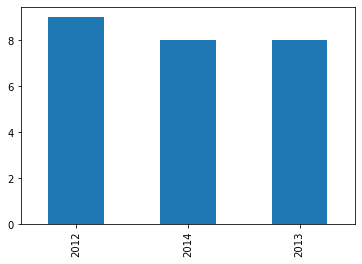

In [4]:
Count_UKHolidays_ByYear =df_UKHolidays["Date"].dt.year.value_counts()
Count_UKHolidays_ByYear.plot.bar() # We can see that we do not have holidays for 2011

# Update Study Time Frame
StudyTimeFrame_StartYear = min(df_UKHolidays["Date"].dt.year)
StudyTimeFrame_EndYear = max(df_UKHolidays["Date"].dt.year)

### Load & Clean ACORN Categories

In [5]:
%time
df_ACORN = pd.read_csv("dataset/acorn_categories.csv")
#df_ACORN.info()

# Rename columns to be read-able
df_ACORN.columns = ['Code', 'Name', 'Group_Name', 'Color']

# Drop duplicates
df_ACORN = df_ACORN.drop_duplicates()

# Remove null data
df_ACORN.dropna()

# Ensure no null values exist in all columns 
# assert df_ACORN.isnull().sum().sum() == 0

Wall time: 0 ns


,Code,Name,Group_Name,Color
0,A,Affluent Achievers,Lavish Lifestyles,dark blue
1,B,Affluent Achievers,Executive Wealth,dark blue
2,C,Affluent Achievers,Mature Money,dark blue
3,D,Rising Prosperity,City Sophisticates,purple
4,E,Rising Prosperity,Career Climbers,purple
5,F,Comfortable Communities,Countryside Communities,green
6,G,Comfortable Communities,Successful Suburbs,green
7,H,Comfortable Communities,Steady Neighbourhoods,green
8,I,Comfortable Communities,Comfortable Seniors,green
9,J,Comfortable Communities,Starting Out,green


### Load & Clean Households

In [6]:
%time
df_Households = pd.read_csv("dataset/informations_households.csv")
#df_Households.info()

# Select only relevent columns
df_Households = df_Households[['LCLid', 'Acorn']]

# Rename columns to be read-able
df_Households.columns = ['ID', 'ACORN_Category']

# Apply striping of "ACORN-" from category code
df_Households['ACORN_Category'] = df_Households['ACORN_Category'].apply(lambda x: x.upper().replace('ACORN-','').strip())

df_Households_invalid = pd.DataFrame() 
# Remove Empty ACORN categories
df_Households_invalid = df_Households_invalid.append(df_Households[df_Households['ACORN_Category']==""])
df_Households = df_Households[df_Households['ACORN_Category']!=""]

# Remove invalid ACORN categories
df_Households_invalid = df_Households_invalid.append(df_Households[~df_Households['ACORN_Category'].isin(df_ACORN['Code'])])
df_Households = df_Households[df_Households['ACORN_Category'].isin(df_ACORN['Code'])]

# Replace ACORN category code with category name (to group data by ACORN categery rather ACORN group)
df_Households['ACORN_Category'] = df_Households['ACORN_Category'].map(df_ACORN.set_index('Code')['Name'])

# Drop duplicates by ID
df_Households = df_Households.drop_duplicates(subset=['ID'])

# Remove null data
df_Households.dropna()

# Ensure no null values exist in all columns 
# assert df_Households.isnull().sum().sum() == 0

Wall time: 0 ns


,ID,ACORN_Category
2,MAC000002,Affluent Achievers
3,MAC003613,Affluent Achievers
4,MAC003597,Affluent Achievers
5,MAC003579,Affluent Achievers
6,MAC003566,Affluent Achievers
...,...,...
5512,MAC002185,Urban Adversity
5513,MAC002347,Urban Adversity
5514,MAC000088,Urban Adversity
5515,MAC002331,Urban Adversity


<AxesSubplot:>

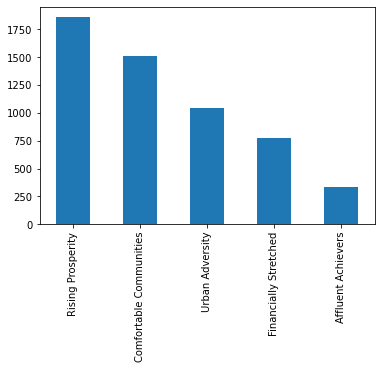

In [7]:
Count_Households_ByACORNCategory = df_Households["ACORN_Category"].value_counts()
Count_Households_ByACORNCategory.plot.bar() # Visualization to see distribution of houses on ACORN categories

### Load & Clean Weather Data

In [8]:
%time
df_Weather = pd.read_csv("dataset/weather_daily_darksky.csv")
#df_Weather.info()

# Select only relevent columns
df_Weather = df_Weather[['time', 'temperatureMax', 'temperatureMin']]

# Rename columns to be read-able
df_Weather.columns = ['Date', 'Temp_Max', 'Temp_Min']

# Convert 'Date' to DateTime data type
df_Weather['Date'] = pd.to_datetime(df_Weather['Date'])

# Drop duplicates by Date
df_Weather = df_Weather.drop_duplicates(subset=['Date'])

# Remove null data
df_Weather.dropna()

# Calculate the Average Temperature for each day
df_Weather['Temp_Avg'] = np.mean([df_Weather['Temp_Max'], df_Weather['Temp_Min']], axis=0)

# Sort by Date
df_Weather = df_Weather.sort_values(by='Date')

df_Weather.head()

# Ensure no null values exist in all columns 
# assert df_Weather.isnull().sum().sum() == 0

Wall time: 0 ns


,Date,Temp_Max,Temp_Min,Temp_Avg
13,2011-01-11,15.57,9.68,12.625
28,2011-01-12,12.15,6.08,9.115
60,2011-02-11,15.19,8.88,12.035
3,2011-02-12,8.07,2.56,5.315
34,2011-03-11,17.41,12.79,15.100


In [9]:
df_Weather[(df_Weather['Date'].dt.year == 2012)]

,Date,Temp_Max,Temp_Min,Temp_Avg
415,2012-01-01 00:00:00,12.59,7.71,10.150
110,2012-01-02 00:00:00,3.36,-0.92,1.220
295,2012-01-03 00:00:00,15.11,6.49,10.800
365,2012-01-04 23:00:00,15.04,3.98,9.510
393,2012-01-05 23:00:00,13.81,9.73,11.770
...,...,...,...,...
302,2012-12-27 00:00:00,7.97,6.42,7.195
331,2012-12-28 00:00:00,12.34,5.45,8.895
166,2012-12-29 00:00:00,11.97,7.28,9.625
326,2012-12-30 00:00:00,10.90,5.44,8.170


In [21]:
#df_Weather = df_Weather.set_index('Date')

df_weather_bymonth_2012 = df_Weather[(df_Weather['Date'].dt.year == 2012)]

df_weather_bymonth_2012.groupby(df_weather_bymonth_2012['Date'].dt.month)['Temp_Avg'].mean().sort_values()

#df_weather_bymonth_2012.groupby(by= df_weather_bymonth_2012['Date'].dt.month)
#df_weather_bymonth_2012.tail()

#df_Weather[(df_Weather['Date'].dt.year == 2012)].plot(x='Date', y='Temp_Avg', figsize=(20,5))
#df_Weather[(df_Weather['Date'].dt.year == 2012)].plot(x='Date', y='Temp_Min', figsize=(20,5))
#df_Weather[(df_Weather['Date'].dt.year == 2013)].plot(x='Date', y='Temp_Min', figsize=(20,5))
#df_Weather[(df_Weather['Date'].dt.year == 2012) & (df_Weather['Date'].dt.month == 1)].sort_values(by='Date')

Date
1      7.567419
12     8.372903
11     8.585167
2      8.972069
4      9.440667
3     10.288750
10    10.527333
9     12.643833
5     13.146290
6     13.541500
7     14.940806
8     15.773226
Name: Temp_Avg, dtype: float64

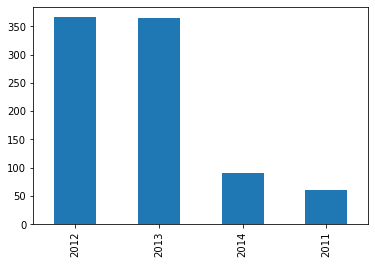

In [11]:
Count_WeatherData_ByYear = df_Weather["Date"].dt.year.value_counts()
Count_WeatherData_ByYear.plot.bar() # We can see that we do not have enough data for 2011 and 2014

# Update Study Time Frame (years that have full daily weather records)
StudyTimeFrame_StartYear = min(Count_WeatherData_ByYear[Count_WeatherData_ByYear >= 365].index)
StudyTimeFrame_EndYear = max(Count_WeatherData_ByYear[Count_WeatherData_ByYear >= 365].index)

# Remove excluded data
df_Weather = df_Weather[(StudyTimeFrame_StartYear <= df_Weather['Date'].dt.year) & (df_Weather['Date'].dt.year <= StudyTimeFrame_EndYear)]